<a href="https://colab.research.google.com/github/cedricng/NLP/blob/main/Word_embeding_M2E_final_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np

- 0) Collecte de données
- 1) Chargement des données textuelles

In [ ]:
Dir='Data/'
texte=[]
for rep in os.listdir(Dir):
    print(rep)
    for files in os.listdir(Dir+rep):
        print(files)
        with open(Dir+rep+'/'+files,"r") as f:
            texte.append(f.read().strip())
    print('#########################')

FileNotFoundError: ignored

In [ ]:
seuil=950000
textes=[]
for elem in texte:
    if len(elem) > seuil:
        for i in range(0,len(elem),seuil):
            textes.append(elem[i:i+seuil])
    else:
        textes.append(elem)

In [ ]:
len(texte),len(textes)

(71, 113)

2) Le nettoyage

liste=[phrase 1, phrase 2, phrase3, phrase N] (où N est le nombre de phrase de tous les textes)
et phrase 1 = [mot1,mot2, ...,motn] (où n est le nombre de mot de la phrase 1)

In [ ]:
import spacy
# Chargement du modele français
nlp = spacy.load('fr_core_news_sm')

In [ ]:
import re # Regular Expressions (re)

def nettoyage(tex):
    # Conserver tous les caracteres sauf les speciaux ($¨#([)) et le chiffres
    p='[a-zA-Zéâûèàùîôêç\-.!?:]{1,}'
    
    # stop words
    with open('stop-w_fr.txt') as f:
        s_w=f.read().split('\n')
    s_w.remove('fait')
    
    # lematizer ou stemmer avec spacy
    
    
    # Laisser un peu de place autour de chaque separateur de phrase
    tex=tex.replace('!',' ! ').replace('.',' . ').replace('?',' ? ').replace(':',' : ')
    tex=' '.join([elem.lemma_ for elem in nlp(tex,disable=['tagger', 'parser', 'ner'])])
    final=[]
    for mot in re.findall(p,tex):
        if mot.lower() not in s_w :
            final.append(mot.lower())
    
    # Manipulation pour mettre les donnees au format d'entrainement
    retour=[]
    phrase=[]
    for tok in final:
        if tok in ".!?:":
            if len(phrase) > 4:
                retour.append(phrase)
                phrase=[]
            else:
                phrase=[]
        else:
            phrase.append(tok.strip())
    return retour


te="Salut à'tous les terriens des grandes visions simplifiées. d $ *$ qdqdd qdjpodkgpg ça va là et Coùcoù les amis nous sommes particulierment heureux!"
nettoyage(te)

[['salut', 'terrien', 'grand', 'vision', 'simplifier'],
 ['qdqdd',
  'qdjpodkgpg',
  'aller',
  'coùcoù',
  'ami',
  'particulierment',
  'heureux']]

In [ ]:
from tqdm import tqdm
entre=[nettoyage(elem) for elem in tqdm(textes)]

liste=[]
for elem in entre:
    liste=liste+elem


100%|██████████| 113/113 [03:12<00:00,  1.70s/it]


3) Construire un modèle type Word2Vec avec gensim

Word2Vec possède différents paramètres, dont les plus importants sont :

– La dimensionnalité de l’espace vectoriel à construire, c'est-à-dire le nombre de descripteurs
numériques utilisés pour décrire les mots (entre 100 et 1000 en général).

– La taille du contexte d’un mot, c'est-à-dire le nombre de termes entourant le mot en question (les
auteurs suggèrent d’utiliser des contextes de taille 10 avec l’architecture Skip-Gram et 5 avec
l’architecture CBOW).

Étant donné que Word2Vec n’est composé que de deux couches, cet algorithme est rapide à
entraîner et à exécuter, ce qui se révèle être un avantage important par rapport à d'autres méthodes
de word embedding.

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=liste, size=80, window=12, min_count=3, workers=8)

In [ ]:
model.save("word2vec.model")

In [ ]:
def nett(tex):
    # Conserver tous les caracteres sauf les speciaux ($¨#([)) et le chiffres
    p='[a-zA-Zéâûèàùîôêç\-.!?:]{1,}'
    
    # stop words
    with open('stop-w_fr.txt') as f:
        s_w=f.read().split('\n')
    s_w.remove('fait')
    
    
    
    # Laisser un peu de place autour de chaque separateur de phrase
    tex=tex.replace('!',' ! ').replace('.',' . ').replace('?',' ? ').replace(':',' : ')
    
    # lematizer ou stemmer
    tex=' '.join([elem.lemma_ for elem in nlp(tex,disable=['tagger', 'parser', 'ner'])])
    
    final=[]
    for mot in re.findall(p,tex):
        if mot.lower() not in s_w :
            final.append(mot.lower())


    return ' '.join(final).strip()


In [ ]:
model.most_similar(nett('christ'))

/home/david/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('jésus', 0.8935998678207397),
 ('sacrer', 0.8599749207496643),
 ('circoncision', 0.8474659323692322),
 ('christianisme', 0.8437423706054688),
 ('saint', 0.8306735754013062),
 ('eucharistie', 0.8291370272636414),
 ('dieu', 0.8259482383728027),
 ('prophète', 0.8215276598930359),
 ('bienheureux', 0.8194591403007507),
 ('sauveur', 0.8065285086631775)]

In [ ]:
model.doesnt_match(nett('voiture bateau rouge moto').split())

/home/david/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.
/home/david/anaconda3/envs/dev/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'rouge'

In [ ]:
#arithmetic operations
model.most_similar(positive=nett('roi femme').split(), negative=nett('homme').split())

/home/david/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('jephté', 0.685691237449646),
 ('reine', 0.6854047775268555),
 ('princesse', 0.6851055026054382),
 ('sultan', 0.679006814956665),
 ('hérodias', 0.6769931316375732),
 ('cardinal', 0.6521223187446594),
 ('badoure', 0.6341452598571777),
 ('prince', 0.631423830986023),
 ('mohammed', 0.63031005859375),
 ('cadette', 0.6281528472900391)]

In [ ]:
model.most_similar(positive=nett('automobile cheval').split(), negative=nett('moteur').split())

/home/david/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('attelage', 0.6992292404174805),
 ('chien', 0.6772733926773071),
 ('auberge', 0.6740537881851196),
 ('mulet', 0.6732149720191956),
 ('monture', 0.6682400703430176),
 ('écurie', 0.6558144092559814),
 ('chasseur', 0.6536445617675781),
 ('caravane', 0.651880145072937),
 ('bagage', 0.6506736874580383),
 ('soldat', 0.6442724466323853)]

In [ ]:
model.wv.get_vector(nett('maison'))

array([-6.4599538e-01, -1.4279811e+00, -5.9948725e-01, -2.2482650e+00,
        1.5752898e-03, -9.8235750e-01, -4.1714343e-01, -1.1957718e+00,
        3.3958232e-01, -2.0545108e+00, -1.1923021e+00, -6.8782669e-01,
        6.9115222e-01,  5.9997767e-01, -2.6789453e+00, -3.7939236e-01,
        1.0547735e-01,  2.6581928e-01,  1.1641549e+00, -3.3980590e-01,
        1.0317030e+00, -1.0834773e+00,  1.0635152e+00,  2.9366796e+00,
       -2.7553099e-01,  2.4722903e+00,  5.2276757e-02,  1.4512022e+00,
       -2.1762323e+00, -1.8749046e+00,  4.3488577e-01,  2.2793734e-01,
       -1.1650620e+00,  2.3197434e+00,  2.5744941e+00, -1.2980177e+00,
       -8.5686460e-02,  1.6155938e+00, -1.2901368e+00, -2.0029023e+00,
       -6.7395008e-01, -1.8232046e+00, -1.5567678e-01, -7.7238679e-01,
       -7.4633080e-01, -2.7302754e-01, -8.7495577e-01,  2.7927709e-01,
       -3.8484633e-01,  2.5755603e+00,  4.7927511e-01,  2.8518753e+00,
       -1.0118201e+00, -5.9938681e-01,  2.8019617e+00,  2.9946902e-01,
      

In [ ]:
i=0
for elem in model.wv.vocab:
    if i < 20 :
        print(elem)
        print(model.wv.get_vector(elem))
        i=i+1

ouvrage
[ 3.1330928e-01  8.4410846e-01  6.8785614e-01 -2.5435913e-01
 -1.3640780e+00  1.5216159e+00 -4.1607359e-01 -8.2439822e-01
  5.0342768e-01 -1.5843339e+00 -1.3493268e+00 -3.5751717e+00
  2.0637553e+00  3.0677125e+00 -1.1562760e+00 -1.0518168e-01
 -1.8934785e+00  2.5689714e+00  3.6096659e-01  6.5269135e-02
 -1.2401016e+00 -2.2786229e+00 -1.1909050e+00  2.7418640e-01
 -2.2443650e+00  1.2625477e+00 -9.6472991e-01  2.0304258e+00
  2.2664781e+00  3.9685741e-01 -2.1446116e+00 -2.1158645e+00
 -1.2666708e-01 -1.3466955e+00  2.0809352e+00 -2.5934689e+00
  4.4805098e-01 -5.6110322e-01 -1.4836573e-03  6.9899184e-01
  4.2426750e-01  2.3016545e-01 -1.7642865e+00  1.4334248e-01
  9.2995620e-01  1.0611515e+00 -2.2252097e+00 -2.2582729e+00
  1.0135503e+00 -1.2504587e+00  2.2107348e+00  4.8326284e-01
 -1.1590662e+00 -1.0181497e+00 -1.8861067e+00 -1.9463625e+00
 -4.8994702e-01 -4.2443287e-01  9.7601461e-01 -1.1380887e+00
  6.8023765e-01  4.7359960e-03 -3.0622095e-01  4.9415404e-01
  1.7554091e+00 

/home/david/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


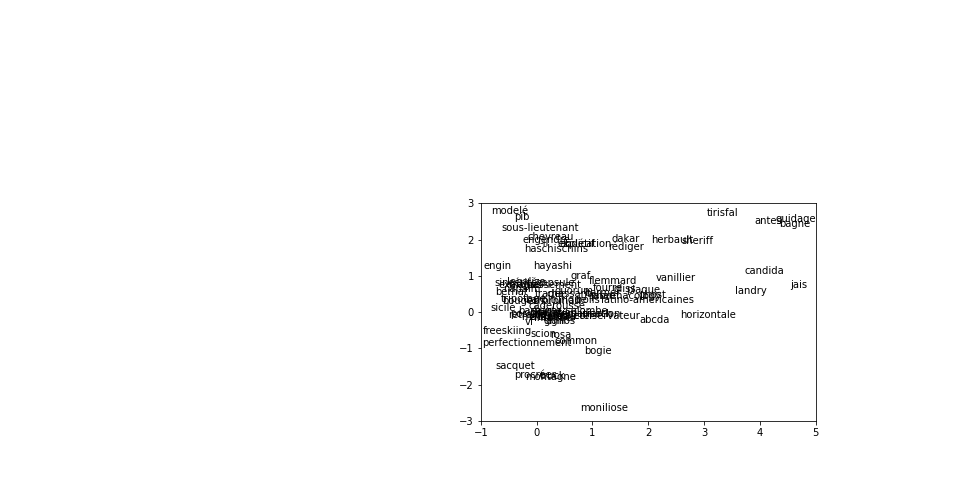

In [ ]:
from sklearn.decomposition import PCA
from matplotlib import pyplot
import random
from pylab import rcParams


# Reduction de dimension 2D pour visualiser
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)


words = list(model.wv.vocab)

for i, word in enumerate(random.choices(words, k=200)):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))

pyplot.axis([-1,5,-3,3])
pyplot.show();

9) Phrase featuring

Construisez une fonction de featurisation de phrase :

input : Chaine de caractère (une phrase)
output: un vecteur sémantique de la taille de l'espace du W2V représentant la phrase

Nous venons de découvrir une autre façon de featurer du texte. En effet, en regroupant les vecteurs
de chaque mot d'une phrase, nous sommes maintenant capable d'en construire un pour une phrase
composée de mots

mot1=(x1,x2,...,x499,x500) mot2=(y1,y2,...,y499,y500)

sentence[mot1,mot2]

sentence=(moyenne(x1,y2),moyenne(x2,y2),...,moyenne(x500,y500))

Il faudra gérer les mots absents du vocabulaire puis sommer ou moyenner ou max ou min ,...
les vecteurs mots entre eux pour créer un vecteur portant la sémantique de la phrase

In [ ]:
def sent_embed(phrase):
    """
    input  : chaine de caractere (un ou plusieurs mots) à vectoriser 
    output : Vecteur associé à la chaine de caractere données en entrée
    """
    l=[]
    for mot in nett(phrase).split():
        try:
            l.append(model.wv.get_vector(mot))
        except:
            continue
    vecs=np.array(l)
    l=[]
    for j in range(vecs.shape[1]):
        l.append(vecs[:,j].mean())
    phrase_vec=np.array(l)
    phrase_vec=phrase_vec.reshape(1,-1)
    return phrase_vec

t="J'aime manger des fruits et des légumes"
t="Je cours dans les bois tous les soirs"
sent_embed(t)

array([[-0.8408459 , -0.06369158, -1.7197384 , -2.3397868 , -0.72968197,
        -1.5708046 ,  0.14754432,  0.31875685, -0.40941384, -0.10019439,
        -1.3484386 ,  0.19314902,  1.0222439 ,  1.7046438 , -0.78948355,
        -0.29876074, -0.48187056,  0.932493  ,  0.41699848, -0.02627291,
        -1.5140781 , -0.6386875 , -0.92733496,  0.7832939 ,  0.12243506,
         1.4927063 , -0.24825813,  0.21032882, -2.303733  , -0.74876946,
        -0.54026395, -0.77954507, -1.6073627 , -0.43598664,  1.7643791 ,
        -1.6092831 ,  0.6813068 ,  0.51331323, -0.8154723 , -1.1482742 ,
        -1.1580956 ,  0.8371865 ,  0.01756692, -0.4874419 , -0.34051725,
         1.4723715 , -0.9622898 ,  0.05950027, -1.195986  ,  0.67076683,
        -0.23601238,  0.9562381 , -0.4312174 , -2.0927155 , -0.28780982,
         0.67057276,  0.08177733,  0.5320246 ,  0.6374221 ,  1.798549  ,
         1.1047171 , -0.19773202, -0.33061543,  1.3013152 ,  0.65026104,
        -0.45409158,  0.6747188 ,  0.5036064 ,  0.0

In [ ]:
#t="J'aime manger des fruits et des légumes"
t="Je cours dans les bois tous les soirs"
t="Je combat de toute mes forces dans les barricades"
t="Sésame ouvre toi"
model.wv.similar_by_vector(sent_embed(t)[0,:], topn=10, restrict_vocab=None)

[('ouvre', 0.9890761375427246),
 ('ouvrir', 0.7440721988677979),
 ('fermé', 0.7109928131103516),
 ('aligner', 0.7109204530715942),
 ('fermer', 0.7062037587165833),
 ('ouvrait', 0.7034279704093933),
 ('grillage', 0.7016193866729736),
 ('pavée', 0.699458122253418),
 ('vitrée', 0.6971789002418518),
 ('ferment', 0.6965796947479248)]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
t1="Je cours dans les bois tous les soirs"
t2="Je combat de toute mes forces dans les barricades"
t3="Elle se repentait déjà de sa résolution. Mais elle fut bientôt en proie à une épouvante plus cruelle que son repentir"
t4="Psg a été crucifié par Marez Riyad en League des champions"
cosine_similarity(sent_embed(t3),sent_embed(t2))

array([[0.5930992]], dtype=float32)

In [ ]:
encoding = tokenizer.encode_plus(question, texte, add_special_tokens=True, return_tensors="pt")